In [1]:
import os
import torch
from model.faster_rcnn_vgg16 import FasterRCNNVGG16
from RCNN.trainer import FasterRCNNTrainer
from data.util import read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
%matplotlib inline

In [2]:
img = read_image('RCNN/dog-cycle-car.png')
img = torch.from_numpy(img)[None]
model_dir = 'model/'

In [3]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/conda/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chun

Exception in user code:
------------------------------------------------------------


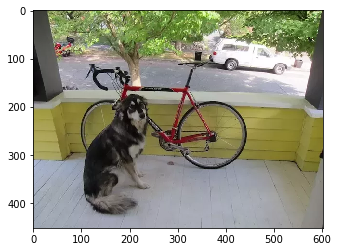

In [4]:
bboxes, labels, scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(bboxes[0]),
         at.tonumpy(labels[0]).reshape(-1),
         at.tonumpy(scores[0]).reshape(-1))


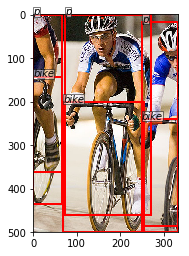

In [8]:
from PascalVOCDataloader import PascalVOCDataloader 
dataset = PascalVOCDataloader('/datasets/ee285f-public/PascalVOC2012/')
image, bboxes, labels = dataset[10]
vis_bbox(at.tonumpy(image),
         at.tonumpy(bboxes),
         at.tonumpy(labels).reshape(-1))